# Деревья решений - Decision Trees

## Данные

Мы будем использовать один и тот же набор данных для всех методов классификации на основе деревьев (Деревья решений - Decision Tree, Случайные леса - Random Forests и Расширяемые деревья - Gradient Boosted Trees). Это позволит нам сравнивать работу этих методов между собой.

Мы будем работать с набором данных "Palmer Penguins" - он достаточно простой для того, чтобы мы могли понять влияние гиперпараметров на результаты классификации.

Данные были собраны и предоставлены Кристиной Горман и антарктической станцией Палмер, расположенной на острове Анверс, к северу от Южного полярного круга.  


* penguins_size.csv: Упрощённые данные из исходного набора данных о пингвинах. Содержит следующие переменные:

    * species: разновидности пингвинов - Антарктический пингвин (Chinstrap), Пингвин Адели (Adélie) или Папуанский пингвин (Gentoo)
    * culmen_length_mm: длина клюва (mm)
    * culmen_depth_mm: высота клюва (mm)
    * flipper_length_mm: длина крыла (mm)
    * body_mass_g: масса тела (g)
    * island: название острова (Dream, Torgersen или Biscoe) на архипелаге Палмер (Антарктика)
    * sex: пол пингвина

**Наша цель - создать модель, которая поможет нам определять вид пингвина на основе его физических атрибутов, чтобы исследователи могли с помощью этой модели классифицировать пингвинов, без необходимости привлечения опытного биолога.**

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
df = pd.read_csv("penguins_size.csv")
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Исследование данных - EDA

### Отсутствующие значения - Missing Data

Если какие-то значения отсутствуют и их немного, то мы можем удалить такие данные. Однако для использования нашей будущей модели мы предполагаем, что для новых пингвинов все признаки будут измеряться без пропусков.

In [4]:
df.shape

(344, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [6]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [10]:
df = df.dropna()

можем удалить отсутствующие данные, так как это всего лишь 3 % от всего объема

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [13]:
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [14]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

# Проверяем уникальные значения

В колонке sex замечаем, что находится точка, далее решим можно ли ее удалить или заменить 

In [15]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [16]:
df[df['sex'] == '.']

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,.


Видим что в данном случае значение с точкой ближе к пингвинам женского пола, чем к мужскому

In [19]:
df[df['species'] == 'Gentoo'].groupby('sex').describe().T

sex                           .       FEMALE         MALE
culmen_length_mm  count     1.0    58.000000    61.000000
                  mean     44.5    45.563793    49.473770
                  std       NaN     2.051247     2.720594
                  min      44.5    40.900000    44.400000
                  25%      44.5    43.850000    48.100000
                  50%      44.5    45.500000    49.500000
                  75%      44.5    46.875000    50.500000
                  max      44.5    50.500000    59.600000
culmen_depth_mm   count     1.0    58.000000    61.000000
                  mean     15.7    14.237931    15.718033
                  std       NaN     0.540249     0.741060
                  min      15.7    13.100000    14.100000
                  25%      15.7    13.800000    15.200000
                  50%      15.7    14.250000    15.700000
                  75%      15.7    14.600000    16.100000
                  max      15.7    15.500000    17.300000
flipper_length_mm count     1.0    58.000000    61.000000
                  mean    217.0   212.706897   221.540984
                  std       NaN     3.897856     5.673252
                  min     217.0   203.000000   208.000000
                  25%     217.0   210.000000   218.000000
                  50%     217.0   212.000000   221.000000
                  75%     217.0   215.000000   225.000000
                  max     217.0   222.000000   231.000000
body_mass_g       count     1.0    58.000000    61.000000
                  mean   4875.0  4679.741379  5484.836066
                  std       NaN   281.578294   313.158596
                  min    4875.0  3950.000000  4750.000000
                  25%    4875.0  4462.500000  5300.000000
                  50%    4875.0  4700.000000  5500.000000
                  75%    4875.0  4875.000000  5700.000000
                  max    4875.0  5200.000000  6300.000000

In [24]:
df.at[336, 'sex'] = 'FEMALE'

## Визуализация

<AxesSubplot:xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

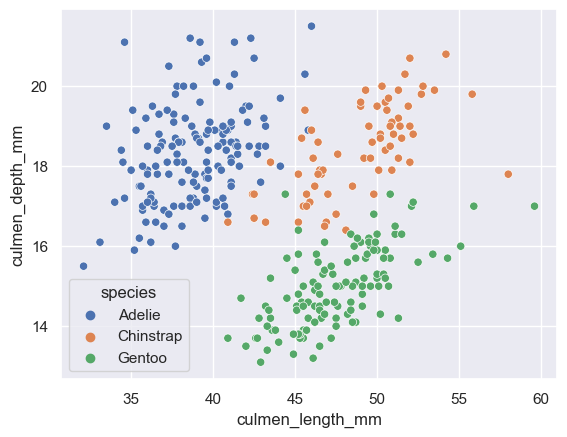

In [27]:
sns.scatterplot(data=df, x='culmen_length_mm', y='culmen_depth_mm', hue='species')

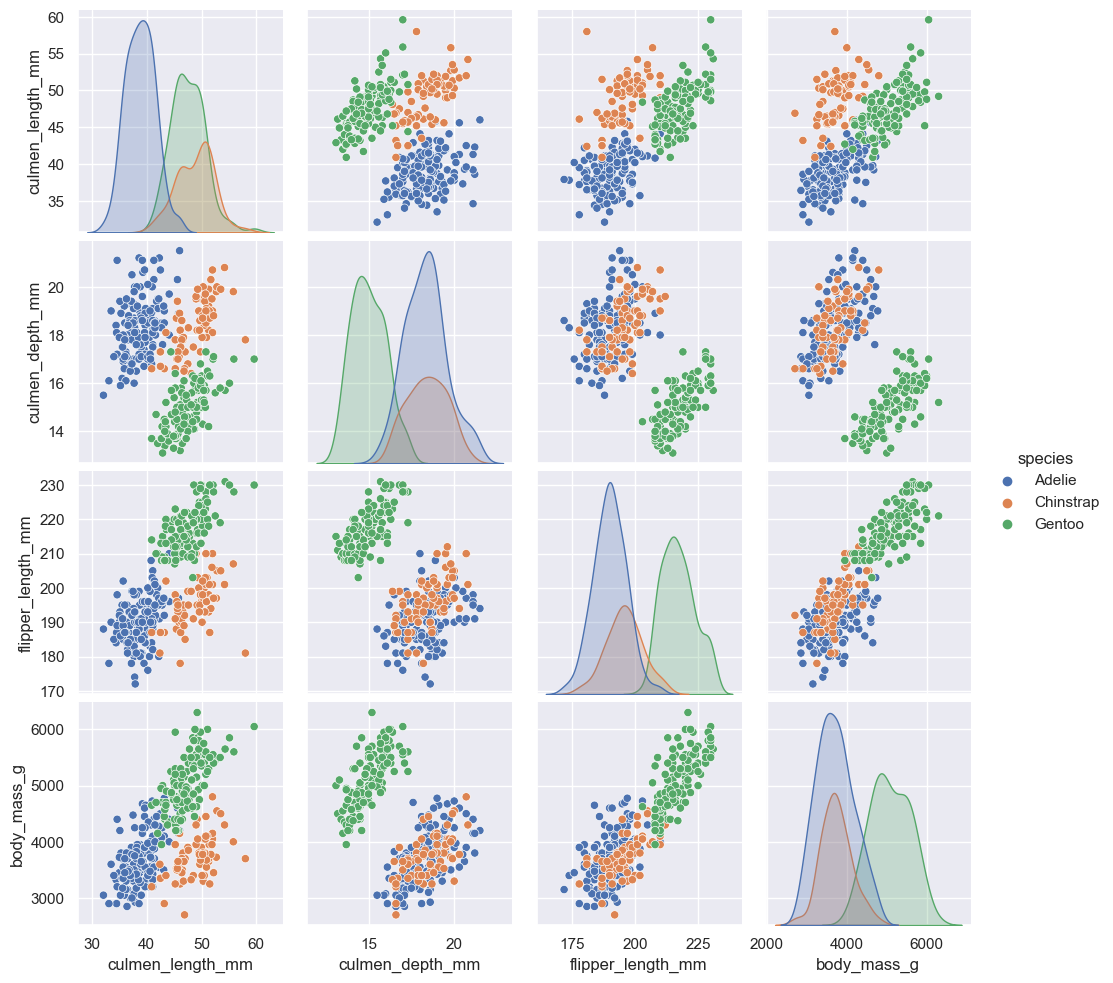

In [29]:
sns.pairplot(data=df, hue='species')

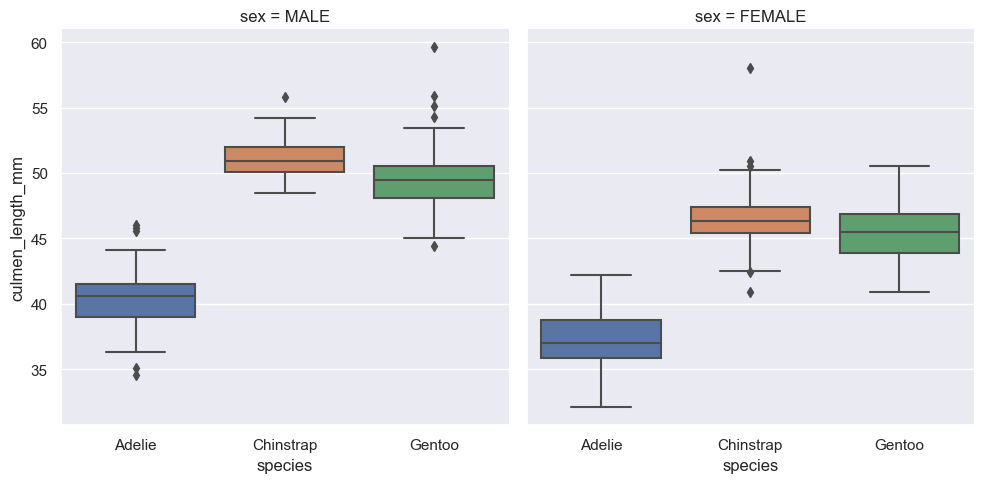

In [34]:
sns.catplot(data=df, x='species', y='culmen_length_mm', col='sex', kind='box')

## Построение признаков - Feature Engineering

In [39]:
X = pd.get_dummies(df.drop('species', axis=1), drop_first=True)
y = df['species']

## Разбиение на обучающий и тестовый наборы данных - Train | Test Split

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Классификатор "Дерево решений" - Decision Tree Classifier

## Гиперпараметры по умолчанию

In [44]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9801980198019802

## Оценка работы модели

In [48]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

pred = model.predict(X_test)
confusion_matrix(y_test, pred)

array([[40,  1,  0],
       [ 1, 22,  0],
       [ 0,  0, 37]])

In [49]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        41
   Chinstrap       0.96      0.96      0.96        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.98       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.98      0.98      0.98       101



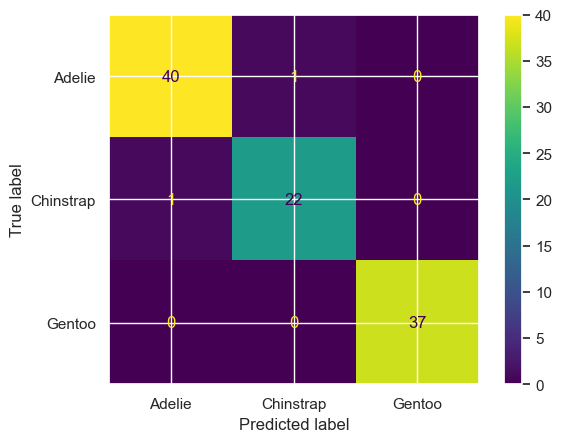

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)

In [51]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
culmen_length_mm,0.337546
culmen_depth_mm,0.042040
flipper_length_mm,0.531201
body_mass_g,0.010853
island_Dream,0.068185
island_Torgersen,0.010175
sex_MALE,0.000000


## Визуализация дерева

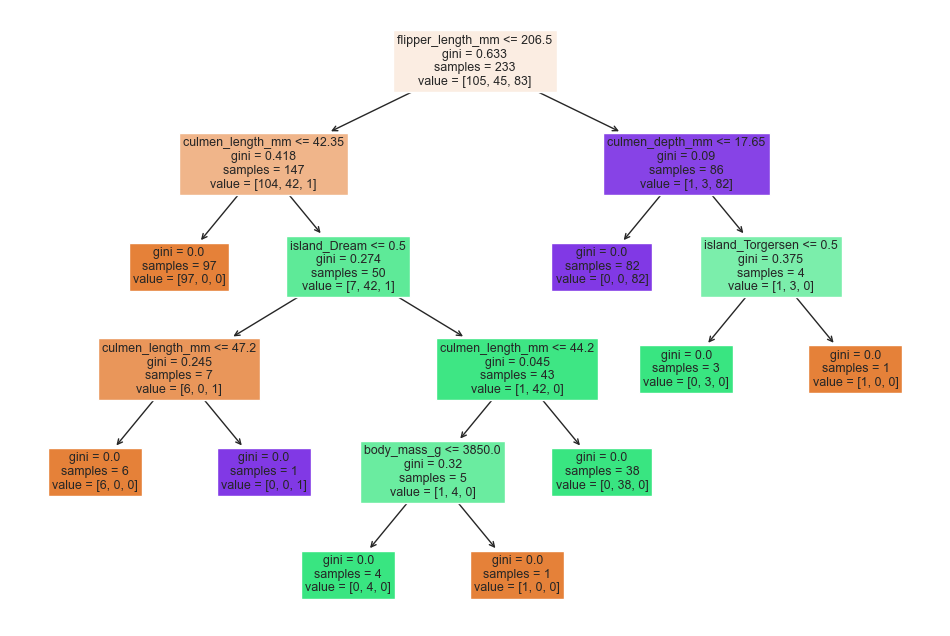

In [52]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
plot_tree(model, feature_names=X.columns, filled=True);